In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import torch
from torch import nn

from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.helperfunctions import train_model, build_dataloader_from_numpy

invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikeWaveforms_NP_SUTempFilter_NPExample_v2'
# invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikes_NPUnits_large.h5'
INVIVO_PATH = os.path.join(paths.INVIVO_DATA_PATH, invivo_name)
INVIVO_FEATURE_PATH = os.path.join(INVIVO_PATH, 'features_' + invivo_name + '.csv')  # in vivo data features

TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_sumstats' # select trial
DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)
CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

model_name = 'RF' # select model
isCNN = 'CNN' in model_name
MODEL_PATH = os.path.join(TRIAL_PATH, model_name)
PRED_PATH = os.path.join(MODEL_PATH, invivo_name, model_name + '_prediction.csv')
CORR_PATH = os.path.join(MODEL_PATH, invivo_name, model_name + '_correlation.csv')

## Load data

In [2]:
corr_type = 'Coss'  # 'Log_Coss'
df_corr = pd.read_csv(CORR_PATH, index_col='cell id')
print('Any nan value: ' + str(df_corr.isna().values.any()))

ids = df_corr.dropna().index.sort_values().values
df_corr = df_corr.loc[ids]
pd_features = pd.read_csv(INVIVO_FEATURE_PATH, index_col='cell id').loc[ids]
df_pred = pd.read_csv(PRED_PATH, index_col=0).loc[ids]
corr = df_corr[corr_type].values

Any nan value: False


## Preprocess data

In [3]:
# labels
layer = df_pred['layer'].values
layer_names = np.sort(np.unique(df_pred['layer'].values))
nlayers = layer_names.size
layer_idx = {L: layer==L for L in layer_names}
layer_clr = np.array(['darkcyan', 'darkred', 'goldenrod'])

layerID = {x: i for i, x in enumerate(layer_names)}
layer2int = np.vectorize(lambda x: layerID[x])
Y = layer2int(layer)
# Y = nn.functional.one_hot(torch.as_tensor(layerid).to(torch.int64), nlayers)

# inputs
ranges = config_dict['Simulation_Parameters']['loc_param_range'].copy()
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

featrue_names = [x for x in config_dict['Simulation_Parameters']['geo_param_list'] if x in config_dict['Trial_Parameters']['inference_list']]
X = np.column_stack([norm_scale(df_pred[f].values, ranges[f]) for f in featrue_names])
# X = np.hstack([X, pd_features[['spike_width']].values])

X = X.astype('float32')
Y = Y.astype('int64')
train_loader, test_loader = build_dataloader_from_numpy(
        input_arr=X, label_arr=Y, keep_dtype=True, batch_size=32, train_size=1., shuffle=True
    )

## Train model

In [4]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes

rand_seed = 0
torch.manual_seed(rand_seed)

claasifier_name = model_name + '_classifier'
model = FullyConnectedNetwork(in_features=X.shape[1], out_features=nlayers, hidden_layer_size=[16, 32, 8])

  5%|██                                        | 5/100 [00:00<00:05, 18.17it/s]

Training Loss: 0.03819891080564382 Validation Loss: 0.0


 21%|████████▌                                | 21/100 [00:00<00:01, 42.91it/s]

Training Loss: 0.03219303002162856 Validation Loss: 0.0
Training Loss: 0.03079148579616936 Validation Loss: 0.0


 38%|███████████████▌                         | 38/100 [00:01<00:01, 46.07it/s]

Training Loss: 0.03392124480130721 Validation Loss: 0.0


 49%|████████████████████                     | 49/100 [00:01<00:01, 47.31it/s]

Training Loss: 0.029599311704538306 Validation Loss: 0.0


 60%|████████████████████████▌                | 60/100 [00:01<00:00, 47.88it/s]

Training Loss: 0.028723287643218527 Validation Loss: 0.0


 65%|██████████████████████████▋              | 65/100 [00:01<00:00, 45.57it/s]

Training Loss: 0.029359949486596242 Validation Loss: 0.0


 76%|███████████████████████████████▏         | 76/100 [00:01<00:00, 46.20it/s]

Training Loss: 0.027793170998291095 Validation Loss: 0.0


 88%|████████████████████████████████████     | 88/100 [00:02<00:00, 49.48it/s]

Training Loss: 0.0294628772808581 Validation Loss: 0.0


100%|████████████████████████████████████████| 100/100 [00:02<00:00, 42.83it/s]

Training Loss: 0.028623073684925934 Validation Loss: 0.0


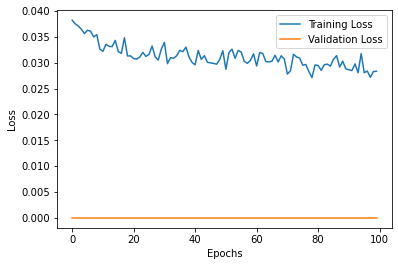

In [5]:
history, _ = train_model(model, train_loader, test_loader, epochs=100, learning_rate=0.005,
                         optimizer='Adam', #torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.25),
                         loss_func=torch.nn.CrossEntropyLoss(), save_model=False)

plt.figure()
plt.plot(history['Epochs'],history['Training_Loss'],label='Training Loss')
plt.plot(history['Epochs'],history['Validation_Loss'],label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluation

In [6]:
device = torch.device('cpu')
model.to(device)
model.eval()

prob = nn.functional.softmax(model(torch.from_numpy(X).to(device)), dim=1).to('cpu').detach().numpy()
y_pred = np.argmax(prob, axis=1)
conf = np.take_along_axis(prob, Y[:, None], axis=1).ravel()
wrong = Y != y_pred

Accuracy: 64.3%


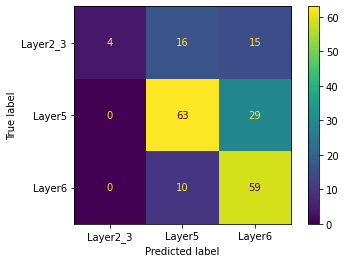

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

print('Accuracy: %.1f%%' % (100 * accuracy_score(Y, y_pred)))

conf_mat = confusion_matrix(Y, y_pred)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=layer_names)

conf_mat_disp.plot()
plt.show()

In [8]:
indices = np.array([[idx & ~wrong, idx & wrong] for idx in layer_idx.values()])
markers = ['.', 'x']

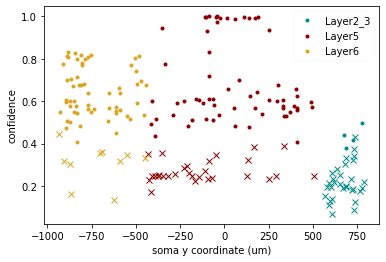

In [9]:
soma_y = df_pred['y'].values

plt.figure()
for i, L in enumerate(layer_idx):
    for j in range(2):
        lb = None if j else L
        plt.plot(soma_y[indices[i, j]], conf[indices[i, j]], marker=markers[j], linestyle='None', color=layer_clr[i], label=lb)
plt.xlabel('soma y coordinate (um)')
plt.ylabel('confidence')
plt.legend(framealpha=0.1)
plt.show()

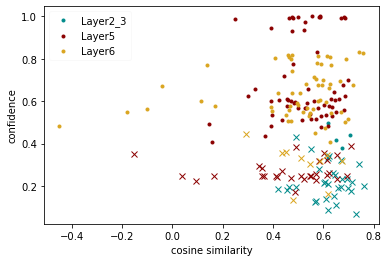

In [10]:
plt.figure()
for i, L in enumerate(layer_idx):
    for j in range(2):
        lb = None if j else L
        plt.plot(corr[indices[i, j]], conf[indices[i, j]], marker=markers[j], linestyle='None', color=layer_clr[i], label=lb)
plt.xlabel('cosine similarity')
plt.ylabel('confidence')
plt.legend(framealpha=0.1)
plt.show()

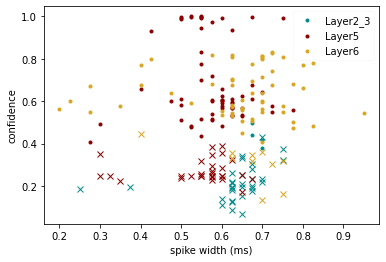

In [11]:
spike_width = pd_features['spike_width'].values

plt.figure()
for i, L in enumerate(layer_idx):
    for j in range(2):
        lb = None if j else L
        plt.plot(spike_width[indices[i, j]], conf[indices[i, j]], marker=markers[j], linestyle='None', color=layer_clr[i], label=lb)
plt.xlabel('spike width (ms)')
plt.ylabel('confidence')
plt.legend(framealpha=0.1)
plt.show()